In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
#import model
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
matplotlib.style.use('ggplot')
from torchvision.datasets import MNIST
import os
import numpy as np
matplotlib.style.use('ggplot')
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import io
import math 
import cv2

from typing import *
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm, trange

# NN
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import STL10

from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.utils.data import DataLoader, Dataset
from torch.distributions import Distribution, Bernoulli, Normal
import torch.nn.functional as F
from torch.nn.functional import binary_cross_entropy

# other  libraries...!!!
%matplotlib inline
import argparse
from skimage.util import random_noise

import time

In [2]:
#############################
#        CLASS              #
############################


# output features for the encoder and input features for the decoder
features = 600
# define a simple linear VAE

def un_flatten(x, channels, h, w):
        return x.view(x.size(0), channels, h, w)
    
def flatten(x):
        return x.view(x.size(0), -1)

class ConvVAE(nn.Module):
    
    # 4 linear layers. MINST data set 96*96*3 image = 27648. 
    
    def __init__(self):
        
        super(ConvVAE, self).__init__()

        self.encode = nn.Sequential(
            # 3 x 96 x 96 -> 3 x 96 x 96
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            # 3 x 96 x 96 -> 32 x 32 x 32
            nn.Conv2d(3, 32, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32 x 32 x 32 -> 64 x 10 x 10
            nn.Conv2d(32, 64, kernel_size=5, stride=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64 x 10 x 10 -> 128 x 4 x 4
            nn.Conv2d(64, 128, kernel_size=5, stride=3, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #
            # 128 x 4 x 4 -> 256 x 2 x 2
            # equivalent to 1024 x 1 x 1 when flattened
            #
            nn.Conv2d(128, 256, kernel_size=3, stride=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # fully-connected and latent space
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)

        self.decode = nn.Sequential(
            # 256 x 2 x 2 -> 128 x 4 x 4
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 128 x 4 x 4 -> 64 x 10 x 10
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64 x 10 x 10 -> 32 x 32 x 32
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32 x 32 x 32 -> 3 x 96 x 96
            nn.ConvTranspose2d(32, 3, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            # 3 x 96 x 96 -> 3 x 96 x 96
            nn.ConvTranspose2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )



    #ENCODER
    def encoder(self, x):
        h = flatten(self.encode(x))
        z, mu, log_var = self.bottleneck(h)
        return z, mu, log_var

    def decoder(self, z):
        z = self.fc3(z)
        z = self.decode(un_flatten(z, channels=256, h=2, w=2))
        return z
    #REPARAMETERIZE
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        #Returns a new tensor with the exponential of the elements of the input tensor input
        std = torch.exp(0.5*log_var) 
        #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    #FORWARD FUNCTION  
    def forward(self, x,high_res_image):
        self.high_res_image = high_res_image
        # encoding
         #Applies the rectified linear unit function element-wise.
        x_org = x
        z, mu, log_var = self.encoder(x)
        reconstruction = self.decoder(z)
        
        BCE, KLD, loss = self.elbo(x_org, reconstruction, mu, log_var)
        
        return reconstruction, mu, log_var , BCE, KLD, loss, z
    
    
    def bottleneck(self, h):
        mu, log_var = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

    #LOSS FUNCTION  
    def elbo(self, x, reconstruction, mu, log_var) :
  
        bce_loss = binary_cross_entropy(reconstruction, self.high_res_image, reduction='sum')
        BCE = bce_loss 
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = KLD + BCE 
        
        return BCE, KLD, loss
        

In [3]:
#############################
#        PARAMETERS          #
############################

batch_size = 64
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)  
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)+1
  height = int(small_image.shape[0] * 100 / scale_percent)+1
  dim = (width, height)  
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA) 
  return low_res_image, image

In [5]:
from torchvision.datasets import STL10

class STL10dataset(STL10):
  def __getitem__(self, index:int):
    img = self.data[index]

    img, target = pixalate_image(np.transpose(img, (1, 2, 0)))

    if self.transform is not None:
        img = self.transform(img)

    if self.target_transform is not None:
        target = self.target_transform(target)

    return img, target

In [6]:
from skimage.metrics import structural_similarity as ssim

def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)


def compare_images(target, ref):  
    return (psnr(target, ref), ssim(target, ref, multichannel =True))

In [7]:
# transforms for training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize((64, 64)),
    #transforms.RandomHorizontalFlip(p=0.25),
    #transforms.RandomPerspective(p=0.25),
    #transforms.ColorJitter(),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    ])

# transforms for test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize((64, 64))
])

# transforms for original image
target_transform = transforms.Compose([
                                transforms.ToTensor(),
                                #transforms.Resize((64, 64))
                            ])

In [8]:
# train and validation data
train_data = STL10dataset(
    root='./data',
    split = 'train',
    download=True,
    transform=train_transform,
    target_transform=target_transform
)

val_data = STL10dataset(
    root='./data',
    split = 'test',
    download=True,
    transform=test_transform,
    target_transform=target_transform
)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [9]:
# Split data into validation and test
test_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4)), len(val_data)))
val_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4))))

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

In [11]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

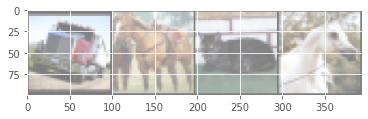

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))


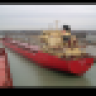

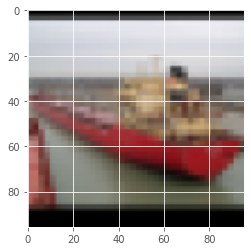

In [13]:

#choose witch image you want to see from 60000
single_image = 1

#take the labels for each train image 


with torch.no_grad():
    
    # Retrieve item
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    #data = data.to(device)
    x = images[1].size()
    # Reshape image
    plt.imshow(images[1].permute(1, 2, 0))

white_torch = images[1]

torchvision.transforms.ToPILImage()(white_torch)

In [14]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(images.size())
compare_images(images[1].permute(1, 2, 0).numpy(),labels[1].permute(1, 2, 0).numpy())

torch.Size([64, 3, 96, 96])


(69.61835532478733, 0.813845395745633)

In [15]:
#############################
#     TRAINING FUNCTION     #
############################

def fit(model, dataloader):
    
    start = time.time()
    model.train()
    running_loss = 0.0
    bce_running_loss = 0.0
    kl_running_loss = 0.0
  
    
    
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, high_res = data
        
        data = data.to(device)
        
       

        high_res = high_res.to(device)
        

        optimizer.zero_grad()
        start = time.time()
        reconstruction, mu, log_var, bce, kl, loss,z = model(data,high_res)
        
        
        running_loss +=   loss.item()
        bce_running_loss += bce.item()
        kl_running_loss += kl.item()
        loss.backward()
        optimizer.step()
        end = time.time()
        #print("Time inside fit: ", end-start)
    train_loss = running_loss/len(dataloader.dataset)
    train_loss_bce = bce_running_loss/len(dataloader.dataset)
    train_loss_kl = kl_running_loss/len(dataloader.dataset)
    

   
    return train_loss, train_loss_bce, train_loss_kl

"""### The Validation Function"""

#############################
#     VALIDATE FUNCTION     #
############################
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    bce_running_loss = 0.0
    kl_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data

            data = data.to(device)
            

            high_res = high_res.to(device)
           

            reconstruction, mu, log_var, bce, kl, loss,z = model(data,high_res)
            
            running_loss += loss.item()
            bce_running_loss += bce.item()
            kl_running_loss += kl.item()

            
    val_loss = running_loss/len(dataloader.dataset)
    val_loss_bce = bce_running_loss/len(dataloader.dataset)
    val_loss_kl = kl_running_loss/len(dataloader.dataset)

    return val_loss, val_loss_bce, val_loss_kl


In [16]:
"""#### Initializing the Model, the Optimizer and the Loss Function"""
epochs = 200
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [17]:
#############################
#            RUN            #
############################

train_loss = []
train_loss_bce = []
train_loss_kl = []

val_loss = []
val_loss_bce = []
val_loss_kl = []

start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    train_epoch_loss, train_epoch_loss_bce, train_epoch_loss_kl = fit(model, train_loader)    
    end = time.time()
    
    val_epoch_loss, val_epoch_loss_bce, val_epoch_loss_kl = validate(model, test_loader)

    
    print(end-start)
    train_loss.append(train_epoch_loss)
    train_loss_bce.append(train_epoch_loss_bce)
    train_loss_kl.append(train_epoch_loss_kl)
    
    val_loss.append(val_epoch_loss)
    val_loss_bce.append(val_epoch_loss_bce)
    val_loss_kl.append(val_epoch_loss_kl)    
    
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")





Epoch 1 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

10.894234418869019
Train Loss: 19460.2882
Val Loss: 19084.8627
Epoch 2 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

17.20064616203308
Train Loss: 19131.7197
Val Loss: 19247.8026
Epoch 3 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

23.60620665550232
Train Loss: 18556.1630
Val Loss: 18139.5352
Epoch 4 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

29.977088928222656
Train Loss: 17202.5655
Val Loss: 16909.4654
Epoch 5 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

36.22684073448181
Train Loss: 16832.8756
Val Loss: 16806.5585
Epoch 6 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

42.55893850326538
Train Loss: 16704.2069
Val Loss: 16689.5098
Epoch 7 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

48.96353840827942
Train Loss: 16651.8140
Val Loss: 16640.9767
Epoch 8 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

56.56687879562378
Train Loss: 16581.7220
Val Loss: 16571.8042
Epoch 9 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

64.02777695655823
Train Loss: 16517.4457
Val Loss: 16508.5778
Epoch 10 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

70.32880806922913
Train Loss: 16477.4993
Val Loss: 16464.1902
Epoch 11 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

76.7807948589325
Train Loss: 16432.2115
Val Loss: 16427.7026
Epoch 12 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

83.19367122650146
Train Loss: 16390.6774
Val Loss: 16381.0529
Epoch 13 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

89.73304486274719
Train Loss: 16361.7927
Val Loss: 16344.8955
Epoch 14 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

96.22142028808594
Train Loss: 16337.9392
Val Loss: 16317.5252
Epoch 15 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

102.79683089256287
Train Loss: 16305.2548
Val Loss: 16303.0046
Epoch 16 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

109.32363367080688
Train Loss: 16285.9855
Val Loss: 16293.2805
Epoch 17 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

115.93193125724792
Train Loss: 16265.5507
Val Loss: 16262.5531
Epoch 18 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

122.46207427978516
Train Loss: 16245.7231
Val Loss: 16338.8815
Epoch 19 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

128.86795091629028
Train Loss: 16236.3407
Val Loss: 16248.8846
Epoch 20 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

135.3985767364502
Train Loss: 16212.9673
Val Loss: 16247.1031
Epoch 21 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

141.9338195323944
Train Loss: 16182.0854
Val Loss: 16206.0129
Epoch 22 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

148.50183629989624
Train Loss: 16171.6147
Val Loss: 16167.8559
Epoch 23 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

155.1379895210266
Train Loss: 16149.2661
Val Loss: 16160.8978
Epoch 24 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

161.87902927398682
Train Loss: 16137.0537
Val Loss: 16148.5927
Epoch 25 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

168.58883333206177
Train Loss: 16126.8454
Val Loss: 16130.1741
Epoch 26 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

175.2319152355194
Train Loss: 16110.6640
Val Loss: 16117.4498
Epoch 27 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

181.88974905014038
Train Loss: 16102.7859
Val Loss: 16110.6347
Epoch 28 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

188.51325941085815
Train Loss: 16082.2979
Val Loss: 16108.6452
Epoch 29 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

195.204745054245
Train Loss: 16080.7345
Val Loss: 16120.1066
Epoch 30 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

201.87334609031677
Train Loss: 16067.1322
Val Loss: 16087.8248
Epoch 31 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

208.55921006202698
Train Loss: 16052.4094
Val Loss: 16112.2446
Epoch 32 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

215.18599891662598
Train Loss: 16049.3619
Val Loss: 16100.8476
Epoch 33 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

221.76735711097717
Train Loss: 16045.5127
Val Loss: 16063.6959
Epoch 34 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

228.44784116744995
Train Loss: 16029.8857
Val Loss: 16073.9784
Epoch 35 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

235.21250009536743
Train Loss: 16019.7091
Val Loss: 16066.8471
Epoch 36 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

241.88956332206726
Train Loss: 16012.1051
Val Loss: 16045.7789
Epoch 37 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

248.45379757881165
Train Loss: 16001.4697
Val Loss: 16064.7967
Epoch 38 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

255.01939702033997
Train Loss: 15958.7567
Val Loss: 15978.1283
Epoch 39 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

261.6579406261444
Train Loss: 15928.2167
Val Loss: 15959.8050
Epoch 40 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

268.29984951019287
Train Loss: 15915.2881
Val Loss: 15981.8850
Epoch 41 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

274.9151940345764
Train Loss: 15895.3693
Val Loss: 15936.7114
Epoch 42 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

281.5241084098816
Train Loss: 15881.8292
Val Loss: 15942.4797
Epoch 43 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

288.18784832954407
Train Loss: 15869.0135
Val Loss: 15904.9877
Epoch 44 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

294.8903913497925
Train Loss: 15853.5564
Val Loss: 15918.0924
Epoch 45 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

301.5002911090851
Train Loss: 15849.0022
Val Loss: 15897.6520
Epoch 46 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

308.1332952976227
Train Loss: 15836.5616
Val Loss: 15888.7709
Epoch 47 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

314.6661903858185
Train Loss: 15826.8206
Val Loss: 15914.2187
Epoch 48 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

321.3812503814697
Train Loss: 15818.2522
Val Loss: 15892.9439
Epoch 49 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

327.97352266311646
Train Loss: 15811.2969
Val Loss: 15872.5247
Epoch 50 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

334.5788278579712
Train Loss: 15802.0452
Val Loss: 15877.3476
Epoch 51 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

341.14074873924255
Train Loss: 15797.6066
Val Loss: 15870.4614
Epoch 52 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

347.84466099739075
Train Loss: 15794.1438
Val Loss: 15873.2751
Epoch 53 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

354.4986062049866
Train Loss: 15785.2416
Val Loss: 15867.6457
Epoch 54 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

361.08746361732483
Train Loss: 15786.5487
Val Loss: 15867.8438
Epoch 55 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

369.89606380462646
Train Loss: 15768.6676
Val Loss: 15833.8169
Epoch 56 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

376.6230425834656
Train Loss: 15760.0343
Val Loss: 15843.5677
Epoch 57 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

383.28229236602783
Train Loss: 15761.0894
Val Loss: 15831.8824
Epoch 58 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

389.94135451316833
Train Loss: 15756.9808
Val Loss: 15826.3046
Epoch 59 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

396.5464549064636
Train Loss: 15749.7895
Val Loss: 15858.0195
Epoch 60 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

403.2450330257416
Train Loss: 15738.3178
Val Loss: 15818.2689
Epoch 61 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

410.0212233066559
Train Loss: 15736.8469
Val Loss: 15809.2038
Epoch 62 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

416.81963562965393
Train Loss: 15722.5460
Val Loss: 15816.3348
Epoch 63 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

423.619261264801
Train Loss: 15723.8320
Val Loss: 15814.6636
Epoch 64 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

430.3577675819397
Train Loss: 15732.4509
Val Loss: 15826.8975
Epoch 65 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

437.01009154319763
Train Loss: 15717.3157
Val Loss: 15791.2757
Epoch 66 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

443.8293948173523
Train Loss: 15720.5673
Val Loss: 15796.3724
Epoch 67 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

450.703058719635
Train Loss: 15708.6595
Val Loss: 15795.3642
Epoch 68 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

457.4270522594452
Train Loss: 15702.4311
Val Loss: 15813.7875
Epoch 69 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

464.1451036930084
Train Loss: 15712.0576
Val Loss: 15792.2646
Epoch 70 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

471.0296378135681
Train Loss: 15701.4459
Val Loss: 15795.4170
Epoch 71 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

477.79431986808777
Train Loss: 15701.8641
Val Loss: 15801.0126
Epoch 72 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

484.57085943222046
Train Loss: 15693.5093
Val Loss: 15822.7215
Epoch 73 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

491.3191258907318
Train Loss: 15686.9335
Val Loss: 15786.7242
Epoch 74 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

497.90608978271484
Train Loss: 15679.0914
Val Loss: 15791.9010
Epoch 75 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

504.6064929962158
Train Loss: 15684.5306
Val Loss: 15775.8538
Epoch 76 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

511.3813614845276
Train Loss: 15677.2509
Val Loss: 15777.9580
Epoch 77 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

518.2484474182129
Train Loss: 15677.7205
Val Loss: 15782.3296
Epoch 78 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

525.0443556308746
Train Loss: 15673.7661
Val Loss: 15802.3782
Epoch 79 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

531.918087720871
Train Loss: 15676.2067
Val Loss: 15787.8525
Epoch 80 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

538.992044210434
Train Loss: 15672.1106
Val Loss: 15800.2966
Epoch 81 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

545.881603717804
Train Loss: 15664.4237
Val Loss: 15776.4991
Epoch 82 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

552.666610956192
Train Loss: 15660.5844
Val Loss: 15779.2069
Epoch 83 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

559.4621930122375
Train Loss: 15658.6932
Val Loss: 15779.4176
Epoch 84 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

566.3305060863495
Train Loss: 15655.1905
Val Loss: 15761.2220
Epoch 85 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

573.120100736618
Train Loss: 15650.8855
Val Loss: 15772.9293
Epoch 86 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

580.0168867111206
Train Loss: 15651.7991
Val Loss: 15761.1825
Epoch 87 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

586.8650872707367
Train Loss: 15648.6566
Val Loss: 15781.6258
Epoch 88 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

593.7352805137634
Train Loss: 15642.9874
Val Loss: 15766.3875
Epoch 89 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

600.6335871219635
Train Loss: 15641.8880
Val Loss: 15767.8749
Epoch 90 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

607.5029678344727
Train Loss: 15639.7515
Val Loss: 15768.1171
Epoch 91 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

614.4559514522552
Train Loss: 15639.7773
Val Loss: 15771.3033
Epoch 92 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

621.3458943367004
Train Loss: 15632.1454
Val Loss: 15761.9112
Epoch 93 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

628.2040324211121
Train Loss: 15638.4936
Val Loss: 15765.9967
Epoch 94 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

635.1860418319702
Train Loss: 15627.5468
Val Loss: 15778.0014
Epoch 95 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

641.9894349575043
Train Loss: 15635.2008
Val Loss: 15761.2014
Epoch 96 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

648.8649272918701
Train Loss: 15627.3885
Val Loss: 15774.2009
Epoch 97 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

655.8280243873596
Train Loss: 15624.3249
Val Loss: 15755.0821
Epoch 98 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

662.685784816742
Train Loss: 15623.9208
Val Loss: 15777.1640
Epoch 99 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

669.5742554664612
Train Loss: 15618.0360
Val Loss: 15763.4750
Epoch 100 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

676.4754881858826
Train Loss: 15625.8741
Val Loss: 15761.4535
Epoch 101 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

685.7851736545563
Train Loss: 15617.8335
Val Loss: 15761.2526
Epoch 102 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

692.7606575489044
Train Loss: 15616.5428
Val Loss: 15790.6434
Epoch 103 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

699.6297700405121
Train Loss: 15608.4814
Val Loss: 15755.6514
Epoch 104 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

706.5875382423401
Train Loss: 15610.8089
Val Loss: 15768.0027
Epoch 105 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

713.5361995697021
Train Loss: 15608.3133
Val Loss: 15753.4434
Epoch 106 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

720.4238231182098
Train Loss: 15607.3037
Val Loss: 15748.5695
Epoch 107 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

727.3547904491425
Train Loss: 15602.6210
Val Loss: 15774.2425
Epoch 108 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

734.1617681980133
Train Loss: 15608.0831
Val Loss: 15773.2680
Epoch 109 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

741.1021933555603
Train Loss: 15605.5782
Val Loss: 15756.1634
Epoch 110 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

748.0614061355591
Train Loss: 15599.0973
Val Loss: 15782.2161
Epoch 111 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

755.0760667324066
Train Loss: 15595.7257
Val Loss: 15744.4231
Epoch 112 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

762.027275800705
Train Loss: 15595.3783
Val Loss: 15780.0585
Epoch 113 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

769.0300652980804
Train Loss: 15597.1589
Val Loss: 15763.8524
Epoch 114 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

775.976390838623
Train Loss: 15596.0267
Val Loss: 15752.7051
Epoch 115 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

783.0011456012726
Train Loss: 15587.8510
Val Loss: 15754.7198
Epoch 116 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

789.8501667976379
Train Loss: 15591.7066
Val Loss: 15757.9836
Epoch 117 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

796.7853815555573
Train Loss: 15586.2918
Val Loss: 15759.2812
Epoch 118 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

803.8134684562683
Train Loss: 15588.8071
Val Loss: 15745.7934
Epoch 119 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

810.9525103569031
Train Loss: 15586.4089
Val Loss: 15751.7430
Epoch 120 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

817.976126909256
Train Loss: 15578.8603
Val Loss: 15759.4113
Epoch 121 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

824.9116220474243
Train Loss: 15585.5865
Val Loss: 15762.9605
Epoch 122 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

831.9603967666626
Train Loss: 15580.7069
Val Loss: 15764.8085
Epoch 123 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

839.0935926437378
Train Loss: 15579.8324
Val Loss: 15743.5700
Epoch 124 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

846.118111371994
Train Loss: 15573.8329
Val Loss: 15744.6967
Epoch 125 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

853.2239747047424
Train Loss: 15572.4304
Val Loss: 15742.1947
Epoch 126 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

860.3089592456818
Train Loss: 15572.5208
Val Loss: 15741.2215
Epoch 127 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

868.218049287796
Train Loss: 15567.5045
Val Loss: 15745.7839
Epoch 128 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

875.32825922966
Train Loss: 15566.3673
Val Loss: 15752.2831
Epoch 129 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

882.4678530693054
Train Loss: 15568.2880
Val Loss: 15756.6683
Epoch 130 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

889.755478143692
Train Loss: 15565.6478
Val Loss: 15751.2762
Epoch 131 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

896.9151666164398
Train Loss: 15563.8253
Val Loss: 15741.3213
Epoch 132 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

904.1192169189453
Train Loss: 15558.7895
Val Loss: 15752.1357
Epoch 133 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

911.2709002494812
Train Loss: 15564.3967
Val Loss: 15745.9993
Epoch 134 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

918.4840607643127
Train Loss: 15556.0246
Val Loss: 15746.2586
Epoch 135 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

925.7834711074829
Train Loss: 15562.1436
Val Loss: 15743.6364
Epoch 136 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

932.9570243358612
Train Loss: 15558.5534
Val Loss: 15757.7486
Epoch 137 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

940.0930979251862
Train Loss: 15561.7126
Val Loss: 15738.9548
Epoch 138 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

947.3836665153503
Train Loss: 15560.0515
Val Loss: 15749.2551
Epoch 139 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

954.4012382030487
Train Loss: 15558.4162
Val Loss: 15740.7436
Epoch 140 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

961.5376300811768
Train Loss: 15551.2084
Val Loss: 15745.8488
Epoch 141 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

968.6000428199768
Train Loss: 15549.3603
Val Loss: 15745.3098
Epoch 142 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

975.5264108181
Train Loss: 15548.4254
Val Loss: 15738.5057
Epoch 143 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

982.5236370563507
Train Loss: 15547.6623
Val Loss: 15745.0899
Epoch 144 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

989.5637638568878
Train Loss: 15546.4554
Val Loss: 15753.1707
Epoch 145 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

998.9215831756592
Train Loss: 15546.3413
Val Loss: 15753.1545
Epoch 146 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1006.0249063968658
Train Loss: 15545.5603
Val Loss: 15739.2313
Epoch 147 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1013.1566174030304
Train Loss: 15546.7547
Val Loss: 15764.1590
Epoch 148 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1020.328040599823
Train Loss: 15541.0271
Val Loss: 15743.4636
Epoch 149 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1027.4360740184784
Train Loss: 15532.8221
Val Loss: 15735.0902
Epoch 150 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1034.4332151412964
Train Loss: 15541.0482
Val Loss: 15754.4183
Epoch 151 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1041.5116262435913
Train Loss: 15546.7503
Val Loss: 15773.3892
Epoch 152 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1048.6699113845825
Train Loss: 15538.6519
Val Loss: 15747.0023
Epoch 153 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1055.8094613552094
Train Loss: 15538.0239
Val Loss: 15749.8288
Epoch 154 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1063.0333771705627
Train Loss: 15534.5303
Val Loss: 15804.0514
Epoch 155 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1070.1599957942963
Train Loss: 15536.3493
Val Loss: 15763.9617
Epoch 156 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1077.3623027801514
Train Loss: 15532.4698
Val Loss: 15744.8285
Epoch 157 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1084.616661787033
Train Loss: 15531.1618
Val Loss: 15740.8374
Epoch 158 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1091.8296029567719
Train Loss: 15528.9024
Val Loss: 15747.3136
Epoch 159 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1098.9703998565674
Train Loss: 15531.0662
Val Loss: 15746.3463
Epoch 160 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1106.0401709079742
Train Loss: 15524.3237
Val Loss: 15742.6985
Epoch 161 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1113.177410364151
Train Loss: 15525.8968
Val Loss: 15744.3649
Epoch 162 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1120.4053025245667
Train Loss: 15522.6618
Val Loss: 15742.8782
Epoch 163 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1127.655564069748
Train Loss: 15524.5710
Val Loss: 15738.6851
Epoch 164 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1134.8026928901672
Train Loss: 15528.4344
Val Loss: 15772.4420
Epoch 165 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1141.9882843494415
Train Loss: 15520.1950
Val Loss: 15752.2257
Epoch 166 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1149.1502318382263
Train Loss: 15528.9880
Val Loss: 15761.5052
Epoch 167 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1156.365755558014
Train Loss: 15519.9057
Val Loss: 15746.5184
Epoch 168 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1163.5022687911987
Train Loss: 15522.9988
Val Loss: 15738.7762
Epoch 169 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1170.828869342804
Train Loss: 15515.8121
Val Loss: 15768.3850
Epoch 170 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1178.0206215381622
Train Loss: 15518.3163
Val Loss: 15750.6075
Epoch 171 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1185.2633473873138
Train Loss: 15520.2533
Val Loss: 15751.0437
Epoch 172 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1192.4665386676788
Train Loss: 15515.3933
Val Loss: 15743.4695
Epoch 173 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1199.7208836078644
Train Loss: 15515.6972
Val Loss: 15752.1555
Epoch 174 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1207.054626941681
Train Loss: 15516.7397
Val Loss: 15758.0962
Epoch 175 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1214.2488944530487
Train Loss: 15510.9932
Val Loss: 15740.1910
Epoch 176 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1221.369277715683
Train Loss: 15515.8255
Val Loss: 15749.9563
Epoch 177 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1228.5251441001892
Train Loss: 15515.9347
Val Loss: 15752.0452
Epoch 178 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1235.8510930538177
Train Loss: 15512.8897
Val Loss: 15745.5344
Epoch 179 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1243.1066558361053
Train Loss: 15505.0847
Val Loss: 15742.1671
Epoch 180 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1250.3499448299408
Train Loss: 15504.2118
Val Loss: 15745.2843
Epoch 181 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1257.6101274490356
Train Loss: 15504.7256
Val Loss: 15737.8049
Epoch 182 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1265.048238992691
Train Loss: 15508.7026
Val Loss: 15756.7435
Epoch 183 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1272.230843782425
Train Loss: 15501.8316
Val Loss: 15745.7543
Epoch 184 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1279.4624609947205
Train Loss: 15501.0795
Val Loss: 15734.3076
Epoch 185 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1286.8184466362
Train Loss: 15503.4221
Val Loss: 15774.0479
Epoch 186 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1294.1494026184082
Train Loss: 15507.2271
Val Loss: 15751.5487
Epoch 187 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1301.8472485542297
Train Loss: 15504.2991
Val Loss: 15735.1227
Epoch 188 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1311.140558719635
Train Loss: 15502.6789
Val Loss: 15759.3907
Epoch 189 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1318.583515405655
Train Loss: 15504.4774
Val Loss: 15772.9165
Epoch 190 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1326.4099488258362
Train Loss: 15504.0340
Val Loss: 15738.8369
Epoch 191 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1333.8223896026611
Train Loss: 15503.3128
Val Loss: 15761.1611
Epoch 192 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1341.2217717170715
Train Loss: 15497.1593
Val Loss: 15768.4466
Epoch 193 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1348.5849554538727
Train Loss: 15496.1467
Val Loss: 15734.4096
Epoch 194 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1356.0159935951233
Train Loss: 15490.6648
Val Loss: 15746.6877
Epoch 195 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1363.5046849250793
Train Loss: 15494.0454
Val Loss: 15748.5317
Epoch 196 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1370.970278263092
Train Loss: 15496.6593
Val Loss: 15754.6743
Epoch 197 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1378.5359015464783
Train Loss: 15494.4635
Val Loss: 15742.5314
Epoch 198 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1386.1471967697144
Train Loss: 15493.4886
Val Loss: 15749.0709
Epoch 199 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1393.6069407463074
Train Loss: 15495.6746
Val Loss: 15754.6982
Epoch 200 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1400.9514293670654
Train Loss: 15488.4556
Val Loss: 15739.6576


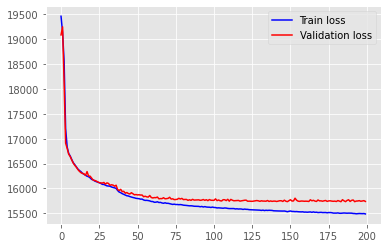

In [18]:


plt.plot(list(range(0,epochs)), train_loss, color='blue', label='Train loss')
plt.plot(list(range(0,epochs)), val_loss, color = 'red', label='Validation loss')
plt.legend()

In [19]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image

with torch.no_grad():
    
    # Retrieve item
    dataiter = iter(train_loader)
    input, target = next(dataiter)
    print(input.size())
    data = input[1].to(device)
    data = data.unsqueeze(0)
    labels = target[1].to(device)
    labels = labels.unsqueeze(0)

    reconstruction, mu, log_var, bce, kl, loss ,z = model(data,labels)
   

torch.Size([64, 3, 96, 96])


In [20]:
input_img = input[1]
target_img = target[1]
out_img = reconstruction.cpu().squeeze(0)
#out_img = out_img.view(data.size(0), -1)
#out_img = out_img.reshape(3,96,96)

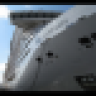

In [21]:
torchvision.transforms.ToPILImage()(input_img)

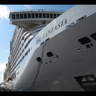

In [22]:
torchvision.transforms.ToPILImage()(target_img)

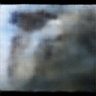

In [23]:
torchvision.transforms.ToPILImage()(out_img)

In [ ]:
compare_images(input_img.permute(1, 2, 0).numpy(),target_img.permute(1, 2, 0).numpy())

(70.19915724678012, 0.8430592776071689)

In [ ]:
compare_images(out_img.permute(1, 2, 0).numpy(),target_img.permute(1, 2, 0).numpy())

(65.88236950372772, 0.5867858105327085)

In [24]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1,
                                          shuffle=False, num_workers=2)

In [25]:
#############################
#     TEST FUNCTION     #
############################
def test(model, dataloader):
    mse_loss = nn.functional.mse_loss
    model.eval()
    running_loss = 0.0
    mse_running_loss = 0.0
    psnr_running_loss = 0.0
    ssim_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data

            data = data.to(device)
            

            high_res = high_res.to(device)
            

            reconstruction, _, _, _, _, loss, _ = model(data,high_res)

            psnr, ssim = compare_images(high_res.view((high_res.size(2), high_res.size(3), high_res.size(1))).cpu().numpy(), reconstruction.view((reconstruction.size(2), reconstruction.size(3), reconstruction.size(1))).cpu().numpy())
            
            running_loss += loss.item()
            psnr_running_loss += psnr
            ssim_running_loss += ssim
            mse_running_loss += mse_loss(reconstruction, high_res)          
            
            
    test_loss = running_loss/len(dataloader.dataset)
    psnr = psnr_running_loss/len(dataloader.dataset)
    ssim = ssim_running_loss/len(dataloader.dataset)
    mse = mse_running_loss/len(dataloader.dataset)


    return test_loss, psnr, ssim, mse.cpu().item()


In [26]:
test_loss, test_psnr, test_ssim, test_mse = test(model, val_loader)

  0%|          | 0/3200 [00:00<?, ?it/s]

In [29]:
test_loss, test_psnr, test_ssim, test_mse

(15739.710983428955,
 66.22504163710036,
 0.6108800109706312,
 0.01733502373099327)

In [38]:
def metrics_on_loader(dataloader):
    psnr_running_loss = 0.0
    ssim_running_loss = 0.0
    mse_loss = nn.functional.mse_loss
    mse_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data
            data = data.cpu()
            high_res = high_res.cpu()
            
            _psnr, _ssim = compare_images(high_res.view((high_res.size(2), high_res.size(3), high_res.size(1))).numpy(), data.view((data.size(2), data.size(3), data.size(1))).numpy())
            

            psnr_running_loss += _psnr
            ssim_running_loss += _ssim  
            mse_running_loss += mse_loss(data, high_res)          
            
    psnr = psnr_running_loss/len(dataloader.dataset)
    ssim = ssim_running_loss/len(dataloader.dataset)
    mse = mse_running_loss/len(dataloader.dataset)

    return psnr, ssim,mse


In [39]:
metrics_on_loader(val_loader)

  0%|          | 0/3200 [00:00<?, ?it/s]

(72.03550058271182, 0.9020684341688764, tensor(0.0047))

Save images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1,
                                          shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(val_loader)

In [ ]:
input, target = next(dataiter)

In [ ]:
input.size()

torch.Size([1, 3, 96, 96])

In [ ]:
im = target.squeeze(1)
im.size()

torch.Size([1, 3, 96, 96])

In [ ]:
from torchvision.utils import save_image

save_image(im, '/content/drive/MyDrive/Deep_Learning/Data/images/STL5.bmp')